### Some questions to answer:

-  Which features are the most closely related to the app rating?
-  Do the free apps have a significantly different higher rating than the paid apps?
-  Which category has the highest average rating?  Which category has the highest number of installs?  
-  How can we obtain a higher rating for a new app?

We can use machine learning to build a model with the app rating as the response variable.  However, the model would not be practical for predictive purposes in this case because many of the features, such as number of installs and reviews, only emerge after the app has been released for a while.  These variables aren't useful for a new app trying to determine how to get the best rating.  Instead, we can use a model for descriptive purposes to learn more about relationships and relative importance of the features, which can still help new apps boost their ratings at launch.

In [126]:
#import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [331]:
#read in files

apps = pd.read_csv("googleplaystore.csv")
reviews = pd.read_csv("googleplaystore_user_reviews.csv")

### Data Prep

Drop rows with NA for **Rating** column since we need the Y label:

In [332]:
apps = apps[pd.notna(apps.Rating)]

Clean up **Price** column:

In [333]:
#convert string Price to float:
apps['Price'] = apps['Price'].apply(lambda x: x.strip('$'))
apps["Price"] = apps["Price"].apply(pd.to_numeric, args=('coerce',))

In [334]:
apps = apps[pd.notna(apps.Price)]

Convert **Reviews** column to numeric type:

In [335]:
#convert Reviews column to integer:
apps["Reviews"] = pd.to_numeric(apps["Reviews"])
apps = apps[pd.notna(apps.Reviews)]

Convert **Size** column to numeric type:

In [336]:
apps.drop(index=10472, inplace=True)

KeyError: 'labels [10472] not contained in axis'

In [337]:
apps["Size"] = apps["Size"].apply(lambda x: x.strip('M'))
apps["Size"] = apps["Size"].apply(pd.to_numeric, args=('coerce',))

apps['Size'] = apps['Size'].fillna(value=apps.Size.median())  
#fill NAs with column median because the distribution is quite skewed

Convert **Installs** to numeric type:

In [339]:
apps['Installs'] = apps['Installs'].apply(lambda x: x[:-1].replace(',',''))
apps['Installs'] = apps["Installs"].apply(pd.to_numeric, args=('coerce',))

In [340]:
apps = apps[pd.notna(apps.Installs)]

In [341]:
apps['Installs'].head(5)

0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: int64

Aggregate the Reviews dataset:

In [342]:
#Remove NAs from reviews:
reviews.dropna(inplace=True)

#aggregate sentiment scores by app:
gb_app = reviews.groupby("App", as_index=False)[["Sentiment_Polarity", "Sentiment_Subjectivity"]].mean()

In [343]:
#join gb_app onto Apps for the final df:
final = apps.merge(gb_app, on = "App", how="left")

### Exploratory Analysis

Which category has the highest average number of ratings?  The most number of apps?

In [344]:
gb = apps.groupby("Category",as_index=False).agg({'Rating':'mean', 'App':'count', 'Reviews':'mean'})
gb.columns=['Category', 'Avg Num Reviews', 'Avg Rating', 'Num Apps']

In [290]:
gb.sort_values("Avg Rating", ascending=False, inplace=True)
gb.head(5)

,Category,Avg Num Reviews,Avg Rating,Num Apps
10,EVENTS,2515.906250,4.435556,64
8,EDUCATION,253819.141026,4.389032,156
0,ART_AND_DESIGN,26376.000000,4.358065,65
3,BOOKS_AND_REFERENCE,95060.904762,4.346067,231
23,PERSONALIZATION,227923.826531,4.335987,392


In [432]:
gb.sort_values("Num Apps", ascending=False, inplace=True)
gb.head(5)

,Category,Avg Num Reviews,Avg Rating,Num Apps
11,FAMILY,2.348157e+05,4.192272,1747
14,GAME,1.445232e+06,4.286326,1097
29,TOOLS,3.721855e+05,4.047411,734
25,PRODUCTIVITY,3.251189e+05,4.211396,351
20,MEDICAL,4.530349e+03,4.189143,350


In [ ]:
gb.sort_values("Avg Rating", ascending=False, inplace=True)
gb.head(5)

#### Do the free apps have a significantly different rating than the paid apps?

To answer this, we need to conduct a difference in means t-test.

In [42]:
apps.Type.unique()

array(['Free', 'Paid', nan], dtype=object)

In [46]:
from scipy import stats

free = list(apps[apps.Type == 'Free'].dropna()['Rating'])  #there is a bug without the dropna()
paid = list(apps[apps.Type == 'Paid'].dropna()['Rating'])
stats.ttest_ind(free, paid, equal_var = False)

Ttest_indResult(statistic=-3.6156105754780063, pvalue=0.00032025304094651625)

We can see from the very small p-value above that the free vs. paid apps is significantly different.  What is the effect size (difference in means) and which type is rated higher on average?

In [49]:
sum(free)/float(len(free)) - sum(paid)/float(len(paid))

-0.08053369624676687

We find that paid apps are rated higher on average, with a -0.081 difference in means. 

What types of apps are crazy expensive?

In [215]:
apps[apps.Price > 100][['App', 'Category']]

,App,Category
4197,most expensive app (H),FAMILY
4362,💎 I'm rich,LIFESTYLE
4367,I'm Rich - Trump Edition,LIFESTYLE
5351,I am rich,LIFESTYLE
5354,I am Rich Plus,FAMILY
5355,I am rich VIP,LIFESTYLE
5356,I Am Rich Premium,FINANCE
5357,I am extremely Rich,LIFESTYLE
5358,I am Rich!,FINANCE
5359,I am rich(premium),FINANCE


### Data Prep for Modeling

In [345]:
final.columns[final.isna().any()].tolist()

['Current Ver', 'Android Ver', 'Sentiment_Polarity', 'Sentiment_Subjectivity']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2100fd10>]],
      dtype=object)

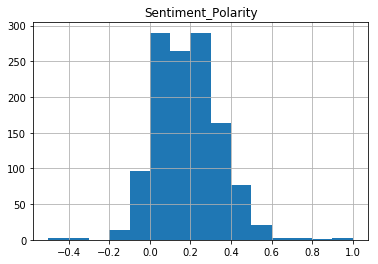

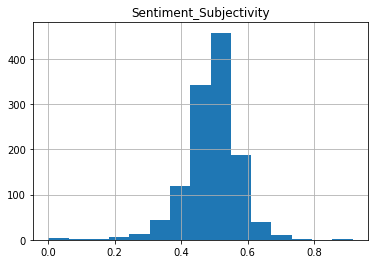

In [346]:
#looks like the sentiment columns have a lot of NAs. 
#Let's look at their distribution to see how to fill in the nulls:

final.hist(column="Sentiment_Polarity", bins=15)

final.hist(column="Sentiment_Subjectivity", bins=15)

In [347]:
#we can use mean to fill in NAs because the distributions are not very skewed

final['Sentiment_Polarity'] = final['Sentiment_Polarity'].fillna(value=final.Sentiment_Polarity.mean())
final['Sentiment_Subjectivity'] = final['Sentiment_Subjectivity'].fillna(value=final.Sentiment_Polarity.mean())

Check for multicollinearity among features:

In [348]:
final['Sentiment_Polarity'].corr(final['Sentiment_Subjectivity'])  
#there is not a high correlation between the 2 features, so we can keep both

0.07208108008511224

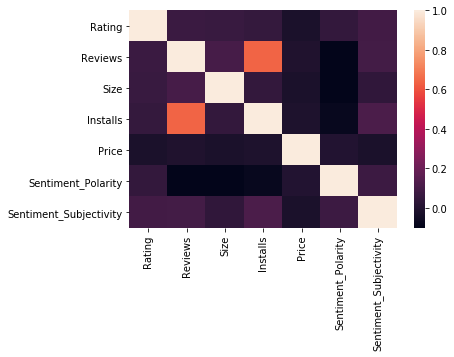

In [349]:
#now check corr matrix for whole df
cor = final.corr()
sns.heatmap(cor)

Installs and Reviews have the highest correlation with each other, but it's less than 0.8 so we will keep both.

In [407]:
final.columns

Index([u'App', u'Category', u'Rating', u'Reviews', u'Size', u'Installs',
       u'Type', u'Price', u'Content Rating', u'Genres', u'Last Updated',
       u'Current Ver', u'Android Ver', u'Sentiment_Polarity',
       u'Sentiment_Subjectivity', u'Current Ver2'],
      dtype='object')

In [408]:
#filter out rows with current ver = NA
final = final[(final["Current Ver"].notnull()) & (final["Current Ver"] != 'Varies with device')]

In [409]:
#convert current version & android version to integers so they can be included in model
final["Current Ver2"] = final["Current Ver"].apply(lambda x: x[0]) #get first character
final["Current Ver2"] = final["Current Ver2"].convert_objects(convert_numeric=True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [410]:
final = final[final["Current Ver2"].notnull()]

### Regression Modeling

Now let's build a regression model, taking the app rating as our response variable.

In [411]:
final.columns[final.isna().any()].tolist()

['Android Ver']

In [412]:
#Get dummies for categorical variables

with_dummies = pd.get_dummies(data=final, columns=['Category', 'Content Rating'])

In [413]:
temp = with_dummies[with_dummies.Rating >= 0]  #weeds out ratings with NA

In [414]:
#build X and Y sets
X = temp.drop(columns=["Rating", "Current Ver", "Last Updated", "Genres", "Type", "App", "Android Ver"])
y = temp["Rating"]

In [420]:
X.columns

Index([u'Reviews', u'Size', u'Price', u'Sentiment_Polarity',
       u'Sentiment_Subjectivity', u'Current Ver2', u'Category_ART_AND_DESIGN',
       u'Category_AUTO_AND_VEHICLES', u'Category_BEAUTY',
       u'Category_BOOKS_AND_REFERENCE', u'Category_BUSINESS',
       u'Category_COMICS', u'Category_COMMUNICATION', u'Category_DATING',
       u'Category_EDUCATION', u'Category_ENTERTAINMENT', u'Category_EVENTS',
       u'Category_FAMILY', u'Category_FINANCE', u'Category_FOOD_AND_DRINK',
       u'Category_GAME', u'Category_HEALTH_AND_FITNESS',
       u'Category_HOUSE_AND_HOME', u'Category_LIBRARIES_AND_DEMO',
       u'Category_LIFESTYLE', u'Category_MAPS_AND_NAVIGATION',
       u'Category_MEDICAL', u'Category_NEWS_AND_MAGAZINES',
       u'Category_PARENTING', u'Category_PERSONALIZATION',
       u'Category_PHOTOGRAPHY', u'Category_PRODUCTIVITY', u'Category_SHOPPING',
       u'Category_SOCIAL', u'Category_SPORTS', u'Category_TOOLS',
       u'Category_TRAVEL_AND_LOCAL', u'Category_VIDEO_PLAYERS

In [415]:
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

The sentiment scores are relatively normally distributed with few outliers, so let's fill in the NAs with the mean of each column.

In [416]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 

mod1 = LinearRegression()
mod1.fit(X_train,y_train)
res1 = mod1.predict(X_test)


Let's evaluate the predictions:

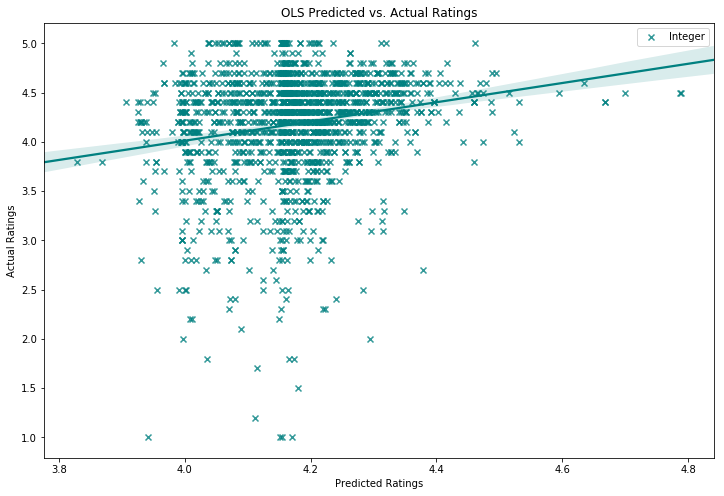

In [417]:
plt.figure(figsize=(12,8))
sns.regplot(res1,y_test,color='teal', label = 'Integer', marker = 'x')
plt.legend()
plt.title('OLS Predicted vs. Actual Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

Compute the MSE for evaluation:

In [418]:
mse_ols = mean_squared_error(y_test, res1)
mse_ols

0.2922868649456363

In [419]:
#get model output with statsmodels OLS method

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
output = res.summary()
output

/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     7.149
Date:                Sun, 20 Jan 2019   Prob (F-statistic):           1.41e-39
Time:                        21:10:51   Log-Likelihood:                -4842.2
No. Observations:                6274   AIC:                             9770.
Df Residuals:                    6231   BIC:                         1.006e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              3.3005      0.067     49.218      0.000       3.169       3.432
Reviews                         1.798e-08   3.61e-09      4.977      0.000    1.09e-08    2.51e-08
Size                               0.0008      0.000      2.500      0.012       0.000       0.001
Price                             -0.0006      0.000     -1.332      0.183      -0.001       0.000
Sentiment_Polarity                 0.5005      0.130      3.860      0.000       0.246       0.755
Sentiment_Subjectivity             0.3216      0.068      4.762      0.000       0.189       0.454
Current Ver2                       0.0058      0.004      1.549      0.121      -0.002       0.013
Category_ART_AND_DESIGN            0.3073      0.075      4.091      0.000       0.160       0.455
Category_AUTO_AND_VEHICLES         0.1000      0.071      1.411      0.158      -0.039       0.239
Category_BEAUTY                    0.2225      0.087      2.564      0.010       0.052       0.393
Category_BOOKS_AND_REFERENCE       0.2641      0.050      5.316      0.000       0.167       0.361
Category_BUSINESS                  0.0247      0.038      0.652      0.514      -0.049       0.099
Category_COMICS                    0.0782      0.083      0.944      0.345      -0.084       0.241
Category_COMMUNICATION             0.0284      0.039      0.732      0.464      -0.048       0.104
Category_DATING                   -0.1447      0.056     -2.577      0.010      -0.255      -0.035
Category_EDUCATION                 0.2730      0.056      4.844      0.000       0.163       0.384
Category_ENTERTAINMENT             0.0212      0.062      0.340      0.734      -0.101       0.144
Category_EVENTS                    0.4165      0.095      4.375      0.000       0.230       0.603
Category_FAMILY                    0.1088      0.018      6.042      0.000       0.074       0.144
Category_FINANCE                   0.0350      0.036      0.967      0.334      -0.036       0.106
Category_FOOD_AND_DRINK           -0.0092      0.065     -0.140      0.888      -0.137       0.119
Category_GAME                      0.1509      0.023      6.489      0.000       0.105       0.196
Category_HEALTH_AND_FITNESS        0.1008      0.038      2.621      0.009       0.025       0.176
Category_HOUSE_AND_HOME            0.0679      0.081      0.835      0.404      -0.091       0.227
Category_LIBRARIES_AND_DEMO        0.1089      0.069      1.580      0.114      -0.026       0.244
Category_LIFESTYLE                -0.0072      0.036     -0.201      0.841      -0.078       0.063
Category_MAPS_AND_NAVIGATION      -0.0351      0.059     -0.590      0.555      -0.152       0.081
Category_MEDICAL                   0.1108      0.033      3.396      0.001       0.047       0.175
Category_NEWS_

### Modeling with random forest

The model above was not that good, since the adjusted R2 was very low.  Let's try other modeling methods.

In [395]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

mod2 = RandomForestRegressor()
mod2.fit(X_train,y_train)
res2 = mod2.predict(X_test)

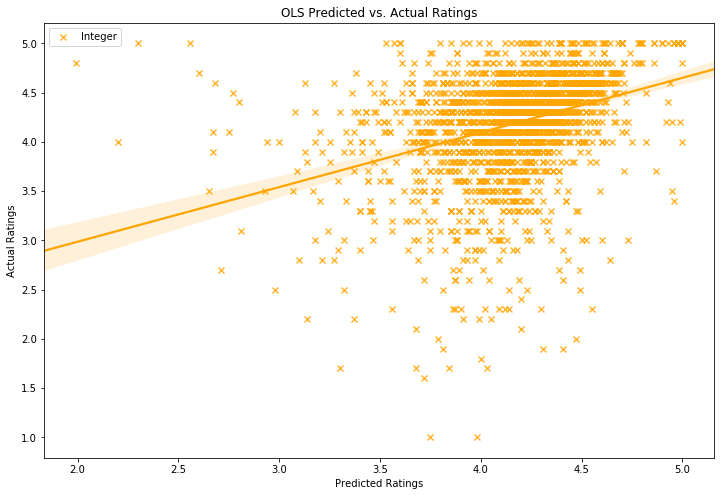

In [396]:
plt.figure(figsize=(12,8))
sns.regplot(res2,y_test,color='orange', label = 'Integer', marker = 'x')
plt.legend()
plt.title('OLS Predicted vs. Actual Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

There is a more positive association for predicted vs. actual ratings using random forest (shown above) than for OLS regression, which means rf is predicting more accurately.  The lower MSE shown below validates this.

In [397]:
mse_rf = mean_squared_error(y_test, res2)
mse_rf

0.25447953122033623

**We can also use rf results to get feature importance rankings:**

<Figure size 1008x720 with 0 Axes>

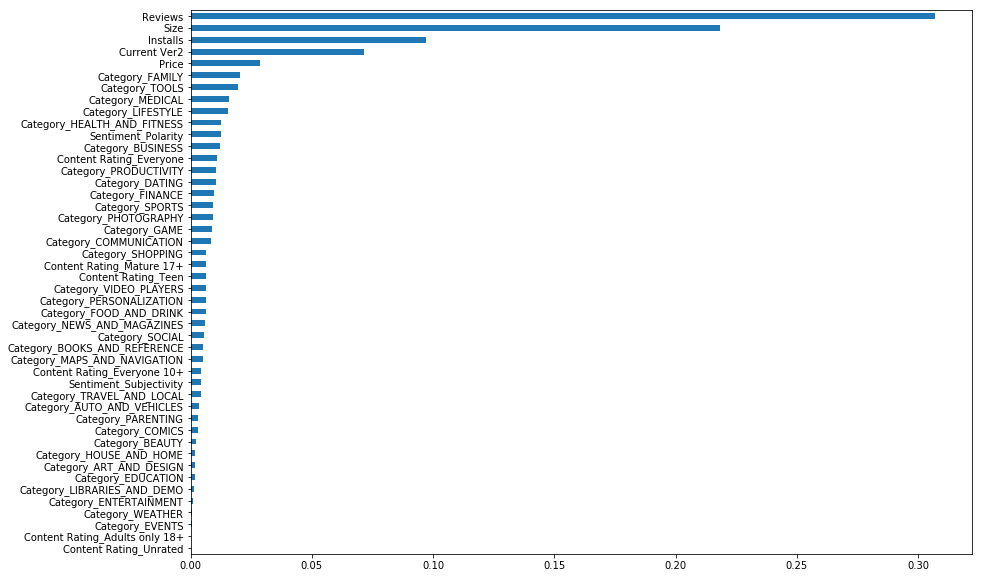

In [398]:
Feat_impt = {}
for col,feat in zip(X.columns,mod2.feature_importances_):
    Feat_impt[col] = feat

Feat_impt_df = pd.DataFrame.from_dict(Feat_impt,orient = 'index')
Feat_impt_df.sort_values(by = 0, inplace = True)
Feat_impt_df.rename(index = str, columns = {0:'Pct'},inplace = True)

plt.figure(figsize= (14,10))
Feat_impt_df.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

**Do the feature rankings make sense?**

1. The number of reviews seems far more important than all the other features, which is surprising at first.  However, it might be a case of reverse causality: the high rating of an app might drive more people to download and review it, not the other way around.  
<br>
2. Size of the app and number of installs also have high importance.  The number of installs might also have a reverse causality with rating.  
<br>
3. The size of the app is a bit surprising, but perhaps size is often associated with better image quality, more app features, etc. which improves the overall user experience and drives higher ratings.  
<br>
4. The 'Current version' feature also ranks quite high in importance, which makes sense because apps with frequent version and updates (often to fix bugs and improve the app) will likely have better ratings.<br>
<br>
5. On the reviews side of things, sentiment polarity ranks much higher in importance than sentiment subjectivity.  This makes sense because polarity represents the overall tone of the review (positive, negative, or neutral), whereas subjectivity involves opinionated statements.

### Modeling with xgboost

In [436]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
mod3 = xgb.XGBRegressor(objective ='reg:linear')
mod3.fit(X_train,y_train)
res3 = mod3.predict(X_test)

In [437]:
mse_xgb = mean_squared_error(y_test, res3)
mse_xgb

0.28458714500220283

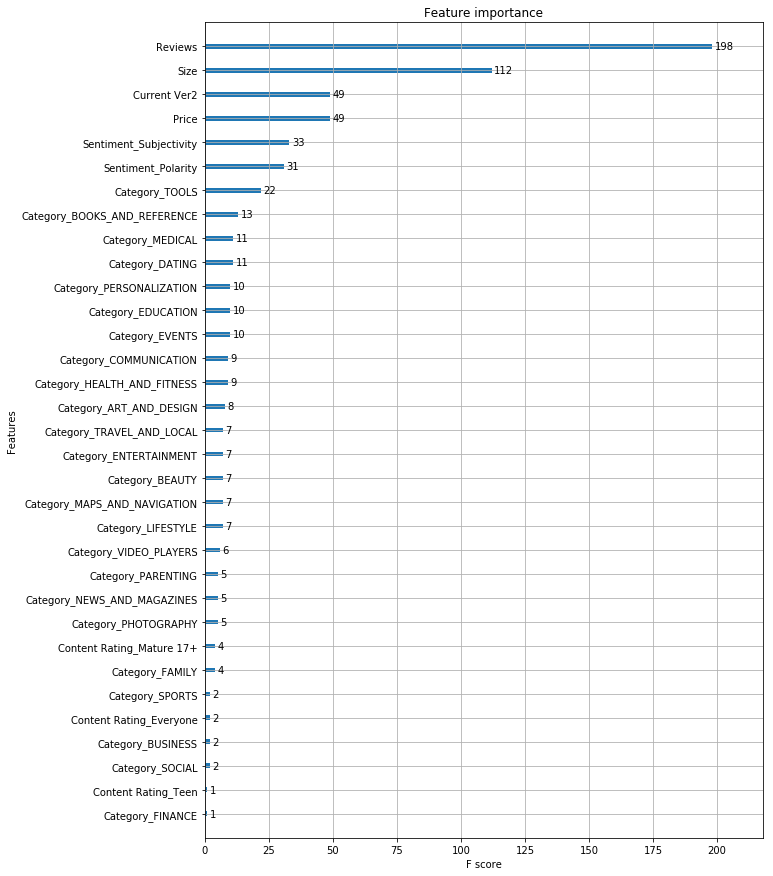

In [438]:
xgb.plot_importance(mod3)
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()

The xgboost feature importance rankings are almost the same as the rf rankings but interestingly, Installs is not ranked here.

Try xgboost with cross-validation:

In [431]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7)
res4 = cross_val_score(mod3, X, y, cv=kfold)
res4.mean()

0.03645905856460115

From the MSEs, xgboost seems to give the most accurate predictions.

### Conclusion

There are several key findings from this analysis:
-  Paid apps are rated significantly different from free apps and are rated higher on average.  However, that does not mean that people rate apps higher because they are paying for them.  Paid apps might likely be more useful, offer more interaction with the user, and so on.<br>
<br>
-  The Family app category has the most apps.  This means there is probably a lot of competition in this area.
<br>
<br>
-  For this particular dataset, xgboost produces the most accurate rating predictions.  However, as noted earlier, we cannot use the model for predictive purposes because we wouldn't have data on some of the important features at the time that the predictions would be needed.
<br>
<br>
-  The number of reviews, installs, size, and current version of the app are the most important features in this data when determining the rating.  However, there are some other important traits not included here, such as more specific categories and whether the app has in-app subscriptions/purchases.